# Trends and shift in rainfall

This will allow for comparing against trends in NDVI seasonality

In [1]:
import os
import sys
import warnings
import xarray as xr
import pandas as pd
import seaborn as sb
import geopandas as gpd
import xarray as xr
from scipy import stats
import contextily as ctx
import numpy as np
import scipy.signal
import contextily as ctx
import matplotlib as mpl
import matplotlib.pyplot as plt
import odc.geo.xr
from odc.geo.xr import assign_crs
from xarrayMannKendall import Mann_Kendall_test

sys.path.append('/g/data/os22/chad_tmp/AusEFlux/src/')
from _prediction import allNaN_arg

sys.path.append('/g/data/os22/chad_tmp/AusEFlux/src/')
from _utils import round_coords

sys.path.append('/g/data/os22/chad_tmp/dea-notebooks/Tools/')
from dea_tools.spatial import xr_rasterize
from dea_tools.temporal import xr_phenology

warnings.simplefilter('ignore')


In [2]:
import sys
sys.path.append('/g/data/os22/chad_tmp/AusEFlux/src/')
from _utils import start_local_dask

client = start_local_dask(mem_safety_margin='2Gb')
client

distributed.nanny.memory - WARNING - Ignoring provided memory limit 200453475328 due to system memory limit of 46.00 GiB


Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: /proxy/8787/status,
Dashboard: /proxy/8787/status,Workers: 1
Total threads: 12,Total memory: 46.00 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:33131,Workers: 1
Dashboard: /proxy/8787/status,Total threads: 12
Started: Just now,Total memory: 46.00 GiB
Comm: tcp://127.0.0.1:33969,Total threads: 12
Dashboard: /proxy/43289/status,Memory: 46.00 GiB
Nanny: tcp://127.0.0.1:45603,


## Analysis Parameters

Start with 5km resolution datasets to speed up exploration

In [3]:
var='rain'
ds_path = '/g/data/os22/chad_tmp/climate-carbon-interactions/data/5km/rain_5km_monthly_1981_2022.nc'

chunks=None#dict(latitude=1000, longitude=1000, time=-1)

t_range='1960', '2022'

## Open data

this takes about ~5mins to loop through the 60+ years of rainfall.

In [4]:
base='/g/data/gh70/ANUClimate/v2-0/stable/month/'
var =  'rain'

years = [str(i) for i in range(1960,2023)]
gbox = xr.open_dataset('/g/data/os22/chad_tmp/climate-carbon-interactions/data/5km/WCF_5km_monthly_1982_2022.nc').odc.geobox

i=0
pp = []
for y in years:
    print(" {:02}/{:02}\r".format(i + 1, len(years)), end="")
    ds = xr.open_mfdataset([base+var+'/'+y+'/'+i for i in os.listdir(base+var+'/'+y+'/')],
                              chunks=dict(lat=1000, lon=1000))
    
    ds = assign_crs(ds, crs='epsg:4283') #GDA94
    ds = ds.drop('crs')[var]
    ds.attrs['nodata'] = np.nan
    ds = ds.odc.reproject(gbox, resampling='average').compute()
    ds = round_coords(ds)
    pp.append(ds)
    i+=1

ds = xr.concat(pp, dim='time').sortby('time')
ds = ds.compute()
ds = ds.rename(var)

In [5]:
ds = assign_crs(ds, crs='EPSG:4326')
# ds = ds.sel(time=slice(t_range[0], t_range[1]))

ds = ds.rename({'latitude':'y', 'longitude':'x'})
# ds = ds.rolling(time=3, min_periods=3).sum()
# ds = ds.sel(time=slice('1982','2022'))

## Shifts in timing of peak rainfall

mask non-seasonal areas same as NDVI phenology trend analysis.

In [6]:
ndvi_path = '/g/data/os22/chad_tmp/climate-carbon-interactions/data/NDVI_harmonization/LGBM/NDVI_CLIM_LGBM_5km_monthly_1982_2022_noGaps.nc'
ndvi = assign_crs(xr.open_dataset(ndvi_path)['NDVI'], crs='EPSG:4326')
ndvi = ndvi.sel(time=slice(t_range[0], t_range[1]))
ndvi = ndvi.rename({'latitude':'y', 'longitude':'x'})

# # Savitsky-Golay
ndvi = xr.apply_ufunc(
        scipy.signal.savgol_filter,
        ndvi,
        input_core_dims=[['time']],
        output_core_dims=[['time']],
        kwargs=dict(
            window_length=3,
            polyorder=2,
            deriv=0,
            mode='interp'),
        dask='allowed'
    )
#SG cuts of last 6 months so clip to complete calendar years.
ndvi = ndvi.sel(time=slice('1982', '2021'))

In [7]:
#standardized anom
def anomalies(ds):
    return xr.apply_ufunc(
        lambda x, m: (x - m),
            ds.groupby("time.month"),
            ds.groupby("time.month").mean()
    )

# 3. Mean NDVI
mean_ndvi = ndvi.mean('time')

##Mask very low NDVI (get rid of remnant water etc.)
low_ndvi_mask = xr.where(mean_ndvi<0.115,0, 1)
mean_ndvi = mean_ndvi.where(low_ndvi_mask)
    
# 1. calculate anomalies
ndvi_std_anom = anomalies(ndvi)
# 2. std dev in anomalies
anom_std = ndvi_std_anom.std('time').where(low_ndvi_mask)
# 4. Std deviation of the mean seasonal pattern
std_mean_season = ndvi.groupby("time.month").mean().std('month').where(low_ndvi_mask)

low_seasonal_variability_low_ndvi = xr.where((std_mean_season<0.03) & (mean_ndvi<0.3), 1, 0)
low_seasonal_variability_high_anomaly = xr.where((std_mean_season<0.03) &  (anom_std>0.07), 1, 0)
seasonal_mask = xr.where((low_seasonal_variability_low_ndvi) | (low_seasonal_variability_high_anomaly), 0, 1)

In [8]:
#aply the mask
ds = ds.where(seasonal_mask)

### Calculate early and later climatologies

In [9]:
ds_cml = ds.rolling(time=3, min_periods=3).sum()

In [10]:
early_clim = ds_cml.sel(time=slice('1960','1990')).groupby('time.month').mean()
late_clim = ds_cml.sel(time=slice('1991','2022')).groupby('time.month').mean()

early_clim_max = allNaN_arg(early_clim, 'month', 'max')
late_clim_max = allNaN_arg(late_clim, 'month', 'max')

In [11]:
# fig, ax = plt.subplots(1,1, figsize=(5,4))
# early_clim.mean(['x','y']).plot(label='1982-2001', ax=ax)
# late_clim.mean(['x','y']).plot(label='2002-2022', ax=ax)
# ax.legend()
# ax.set(xticks=range(1,13))
# ax.set_xticklabels(["J","F","M","A","M","J","J","A","S","O","N","D"], fontsize=10);


### Difference in climatology

and clean up, e.g.:
- january(1) moves to december(12): 1-12 = -11, which should in fact be -1 (peak rainfall has moved backwards 1 month.)
- December(12) moves to Jan(1): 12-1 = 11, which should in fact be 1 (peak rainfall has moved forwards 1 month.)

In [12]:
diff = (late_clim_max - early_clim_max)
diff_clean = xr.where(diff==11, 1, diff)
diff_clean = xr.where(diff==10, 2, diff_clean)
diff_clean = xr.where(diff==9, 3, diff_clean)
diff_clean = xr.where(diff==-11, -1, diff_clean)
diff_clean = xr.where(diff==-10, -2, diff_clean)
diff_clean = xr.where(diff==-9, -3, diff_clean)

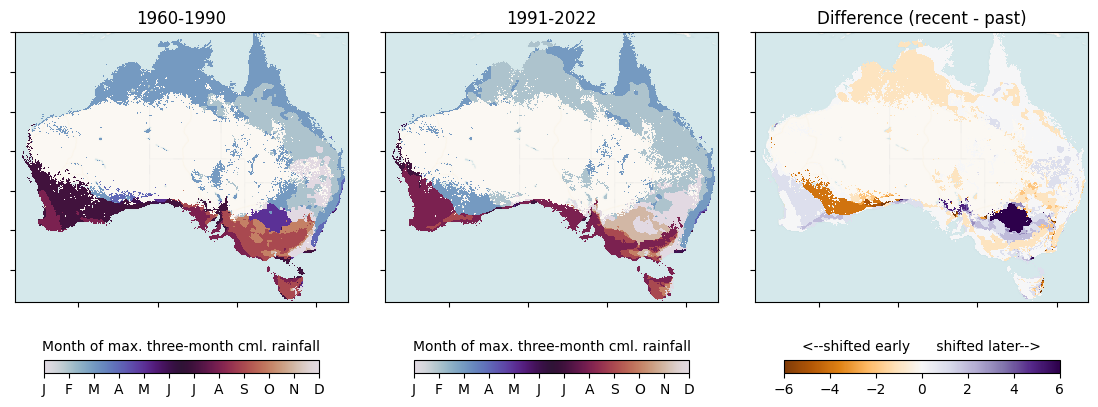

In [13]:
corr_data = [early_clim_max, late_clim_max, (diff_clean)] 
products=['1960-1990', '1991-2022','Difference (recent - past)'] 

fig,axes = plt.subplots(1,3, figsize=(14,5), sharey=True)

for ax, dss, n in zip(axes.ravel(), corr_data, products):
    if n=='Difference (recent - past)':
        cmap='PuOr'
        vmin=-6
        vmax=6
    else:
        cmap='twilight'
        vmin=1
        vmax=12
    im = dss.plot(cmap=cmap, ax=ax, vmin=vmin, vmax=vmax, add_colorbar=False)   
    ctx.add_basemap(ax, source=ctx.providers.CartoDB.VoyagerNoLabels, crs='EPSG:4326', attribution='', attribution_size=1)
    if n=='Difference (recent - past)':
        cbar = fig.colorbar(im, orientation='horizontal',
                ax=ax,
                cmap=cmap,
                ticks=[-6, -4, -2, 0, 2, 4, 6],
                shrink=0.80
               )
        cbar.ax.set_title('<--shifted early      shifted later-->', fontsize=10)
        cbar.ax.tick_params(labelsize=10)
    else:
        cbar = fig.colorbar(im, orientation='horizontal',
                        ax=ax,
                        norm = mpl.colors.Normalize(vmin=1, vmax=12),
                        ticks=[1,2,3,4,5,6,7,8,9,10,11,12],
                        cmap=cmap,
                        shrink=0.80
                       )
        cbar.set_ticklabels(["J","F","M","A","M","J","J","A","S","O","N","D"], fontsize=10)
        cbar.ax.set_title('Month of max. three-month cml. rainfall', fontsize=10)
    ax.set_yticklabels([])
    ax.set_xticklabels([])
    ax.set_title(f'{n}', fontsize=12)
    ax.set_ylabel('')
    ax.set_xlabel('')

plt.subplots_adjust(wspace=0.075)
fig.savefig(f'/g/data/os22/chad_tmp/climate-carbon-interactions/results/figs/peak_3M_rainfall_shifting_patterns.png',
            bbox_inches='tight', dpi=300);

## Trends in rainfall POS

In [26]:
warnings.simplefilter('ignore')
doy = ds.groupby('time.year').map(xr_phenology)

In [41]:
def monthmax(da):
    mask = da.isnull().all('time')
    y = da.fillna(float(da.min() - 1)) 
    return y.argmax(dim='time', skipna=True).where(~mask)

xx = ds.groupby('time.year').map(monthmax)

In [ ]:
pos_trends = Mann_Kendall_test(xx.rename({'year':'time'}),
                               alpha=0.05,
                               method='theilslopes'
                              ).compute()

In [ ]:
fig,ax = plt.subplots(1,1, figsize=(6,6), sharex=True, sharey=True, layout='constrained')

    im = pos_trends.trend.plot(ax=a, add_labels=False, cmap='BrBG', robust=True, add_colorbar=False)
    cb = fig.colorbar(im, ax=a, shrink=0.65, orientation='vertical', label='')
    xr.plot.contourf(vpos_trends.trend.where(vpos_trends.signif), ax=a, alpha=0, hatches=['....'], add_colorbar=False)
    ctx.add_basemap(a, source=ctx.providers.CartoDB.Voyager, crs='EPSG:4326', attribution='', attribution_size=1)
    # a.set_title('Trend in rainfallPOS 1982-2022', fontsize=font)
    
    a.set_yticklabels([])
    a.set_ylabel('')
    a.set_xlabel('')
    a.set_xticklabels([]);

## Trends in seasonal rainfall magnitudes

Just over the 1982-2022 period that covers the satellite era

In [14]:
q_rain = ds.sel(time=slice('1960','2022')).resample(time='Q-DEC', label='left').sum()

In [15]:
mask = xr.where(q_rain.mean('time')==0, 0, 1)
q_rain = q_rain.where(mask)

In [16]:
res = {}
for season in ("DJF", "MAM", "JJA", "SON"):
    print(season)
    xx = q_rain.sel(time=q_rain['time.season']==season)
    xx['time'] = xx.time.dt.year
    _trends = Mann_Kendall_test(xx,
                               alpha=0.05,
                               method='theilslopes'
                              ).compute()
    res[season] = _trends


DJF
MAM
JJA
SON


In [23]:
# res['DJF'].trend.where(res['DJF'].trend!=0).plot(cmap='BrBG', vmin=-5, vmax=5, add_colorbar=False)

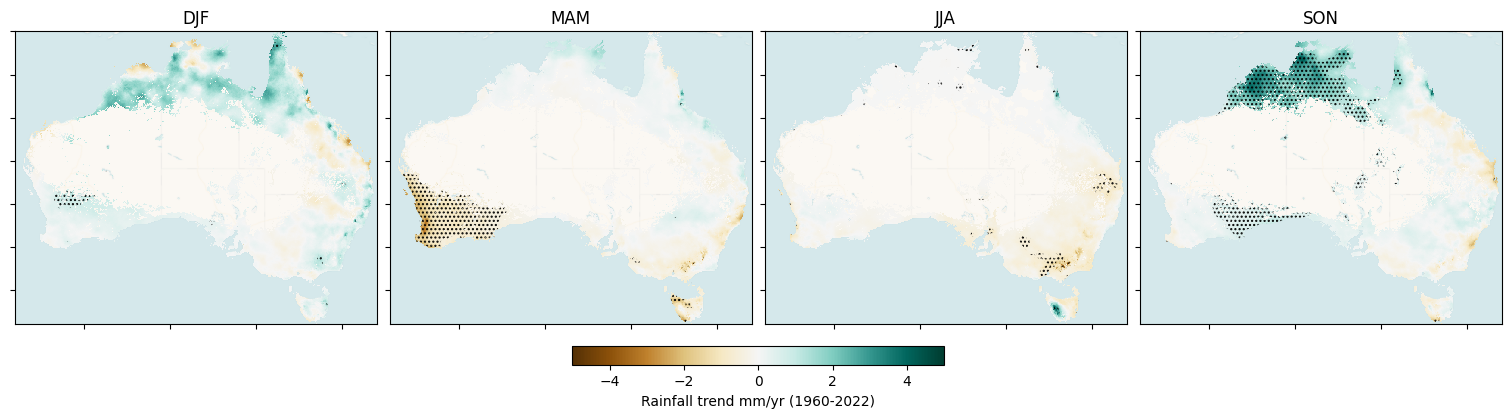

In [27]:
fig,ax = plt.subplots(1,4, figsize=(15,4),sharey=True, layout='constrained')
for s, a in zip(["DJF", "MAM", "JJA", "SON"], ax.reshape(-1)):
    im = res[s].trend.where(res[s].trend!=0).plot(ax=a, cmap='BrBG', vmin=-5, vmax=5, add_colorbar=False)
    ctx.add_basemap(a, source=ctx.providers.CartoDB.VoyagerNoLabels, crs='EPSG:4326', attribution='', attribution_size=1)
    xr.plot.contourf(res[s].trend.where(res[s].signif), ax=a, alpha=0, hatches=['....'], add_colorbar=False)
    a.set_title(s)
    a.set_yticklabels([])
    a.set_ylabel('')
    a.set_xlabel('')
    a.set_xticklabels([]);

cb = fig.colorbar(im, ax=ax, shrink=0.25, orientation='horizontal', label='Rainfall trend mm/yr (1960-2022)')
fig.savefig("/g/data/os22/chad_tmp/climate-carbon-interactions/results/figs/rainfall_seasonal_trends.png", bbox_inches='tight', dpi=300)